In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams.update({'figure.autolayout': False})


def read_sqlite(file):
    conn = sqlite3.connect(file)
    try:
        df = pd.read_sql_query('SELECT * FROM result', conn)
    except:
        return None
    finally:
        conn.close()
    return df

In [2]:
vals = [0.01, 0.017, 0.031, 0.0562, 0.1, 0.178, 0.31, 0.562, 1, 1.778, 3.162, 5.623, 10]
dfs = dict(map(lambda x: (x, read_sqlite('results/duckdb_resilient_tpch1_flip_x_{0:g}_results.sqlite'.format(x))), vals))
# dfs

In [3]:
for val in vals:
    dfs[val]['rate'] = val

In [4]:
merged_df = pd.concat(list(dfs.values()))
merged_df.loc[merged_df['stdout'].notnull() & merged_df['stdout'].str.decode('utf-8').str.startswith('Query Error:'), 'result'] = 3
# merged_df

In [5]:
df = merged_df.groupby(['result', 'rate']).size().reset_index(name='counts')
# df

In [6]:
for result in range(5):
    for rate in vals:
        if len(df[(df['result'] == result) & (df['rate'] == rate)]) == 0:
            df = df.append({
                'result': result,
                'rate': rate,
                'counts': 0
            }, ignore_index=True)

df['result'] = df['result'].astype(int)
df['counts'] = df['counts'].astype(int)
df.sort_values(['result', 'rate'], inplace=True)
# df

In [7]:
pivoted = pd.pivot_table(df, values='counts', index='rate', columns='result')
pivoted.columns = ['ok', 'incorrect', 'crash', 'abnormal', 'timeout']
pivoted

,ok,incorrect,crash,abnormal,timeout
rate,,,,,
0.0100,88915,74,2215,6283,13
0.0170,86184,72,3000,8190,10
0.0310,81463,105,4238,11673,21
0.0562,69378,175,7391,20510,46
0.1000,51369,246,12125,33696,64
0.1780,29398,296,17421,50289,96
0.3100,12018,195,21861,63307,119
0.5620,1873,45,24020,71475,87
1.0000,88,4,24427,72896,85


In [8]:
pivoted / 97500

,ok,incorrect,crash,abnormal,timeout
rate,,,,,
0.0100,0.911949,0.000759,0.022718,0.064441,0.000133
0.0170,0.883938,0.000738,0.030769,0.084000,0.000103
0.0310,0.835518,0.001077,0.043467,0.119723,0.000215
0.0562,0.711569,0.001795,0.075805,0.210359,0.000472
0.1000,0.526862,0.002523,0.124359,0.345600,0.000656
0.1780,0.301518,0.003036,0.178677,0.515785,0.000985
0.3100,0.123262,0.002000,0.224215,0.649303,0.001221
0.5620,0.019210,0.000462,0.246359,0.733077,0.000892
1.0000,0.000903,0.000041,0.250533,0.747651,0.000872


In [8]:
print(pivoted.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &     ok &  incorrect &  crash &  abnormal &  timeout \\
rate    &        &            &        &           &          \\
\midrule
0.0100  &  88915 &         74 &   2215 &      6283 &       13 \\
0.0170  &  86184 &         72 &   3000 &      8190 &       10 \\
0.0310  &  81463 &        105 &   4238 &     11673 &       21 \\
0.0562  &  69378 &        175 &   7391 &     20510 &       46 \\
0.1000  &  51369 &        246 &  12125 &     33696 &       64 \\
0.1780  &  29398 &        296 &  17421 &     50289 &       96 \\
0.3100  &  12018 &        195 &  21861 &     63307 &      119 \\
0.5620  &   1873 &         45 &  24020 &     71475 &       87 \\
1.0000  &     88 &          4 &  24427 &     72896 &       85 \\
1.7780  &      0 &          0 &  25167 &     72290 &       43 \\
3.1620  &      0 &          0 &  27833 &     69638 &       29 \\
5.6230  &      0 &          0 &  33050 &     64441 &        9 \\
10.0000 &      0 &          0 &  42206 &     55283 & 

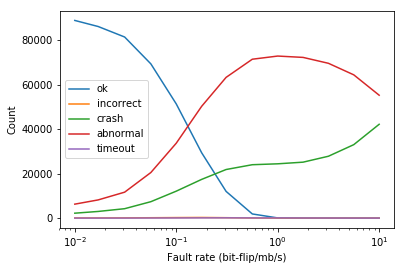

In [21]:
fig = plt.figure()
plt.ylabel('Count')
plt.xlabel('Fault rate (bit-flip/mb/s)')
plt.xscale('log')
plt.plot(vals, pivoted['ok'], label='ok')
plt.plot(vals, pivoted['incorrect'], label='incorrect')
plt.plot(vals, pivoted['crash'], label='crash')
plt.plot(vals, pivoted['abnormal'], label='abnormal')
plt.plot(vals, pivoted['timeout'], label='timeout')
plt.legend()
plt.show()

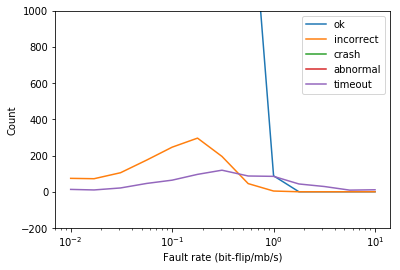

In [24]:
fig = plt.figure()
plt.ylabel('Count')
plt.xlabel('Fault rate (bit-flip/mb/s)')
plt.xscale('log')
plt.plot(vals, pivoted['ok'], label='ok')
plt.plot(vals, pivoted['incorrect'], label='incorrect')
plt.plot(vals, pivoted['crash'], label='crash')
plt.plot(vals, pivoted['abnormal'], label='abnormal')
plt.plot(vals, pivoted['timeout'], label='timeout')
plt.legend()
plt.ylim(-200, 1000)
plt.show()

<IPython.core.display.Javascript object>


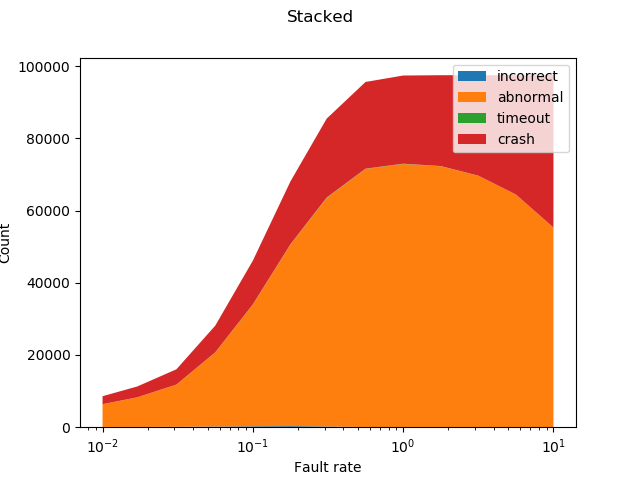

In [11]:
fig = plt.figure()

fig.suptitle('Stacked')
plt.ylabel('Count')
plt.xlabel('Fault rate')
plt.xscale('log')
plt.stackplot(vals,
              pivoted['incorrect'],
              pivoted['abnormal'],
              pivoted['timeout'],
              pivoted['crash'],
              baseline='zero',
              labels=['incorrect', 'abnormal', 'timeout', 'crash'])
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


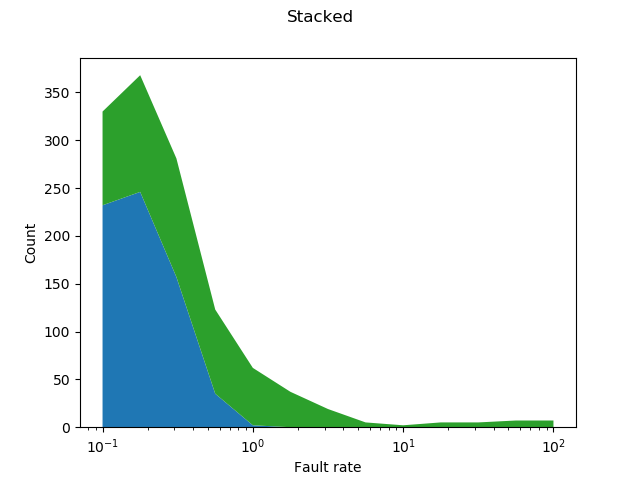

In [12]:
fig = plt.figure()

fig.suptitle('Stacked')
plt.ylabel('Count')
plt.xlabel('Fault rate')
plt.xscale('log')
plt.stackplot(vals,
              pivoted['incorrect'],
              pivoted['abnormal'],
              pivoted['timeout'],
              baseline='zero',
              labels=['incorrect', 'abnormal', 'timeout'])
plt.show()

<IPython.core.display.Javascript object>


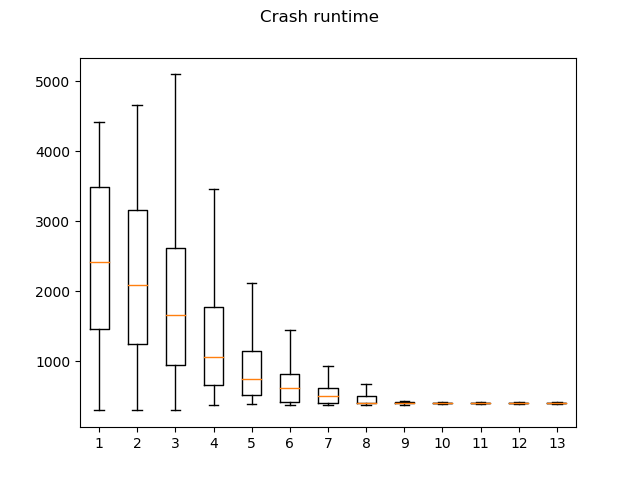

In [13]:
fig = plt.figure()

fig.suptitle('Crash runtime')

df_2 = merged_df[merged_df['result'] == 2]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

<IPython.core.display.Javascript object>


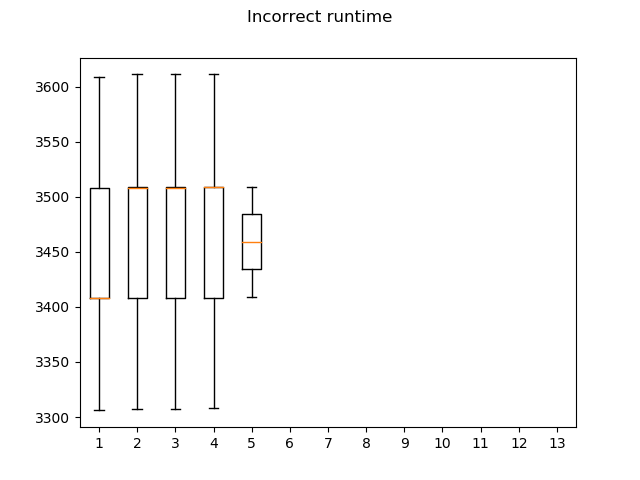

In [14]:
fig = plt.figure()

fig.suptitle('Incorrect runtime')

df_2 = merged_df[merged_df['result'] == 1]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

<IPython.core.display.Javascript object>


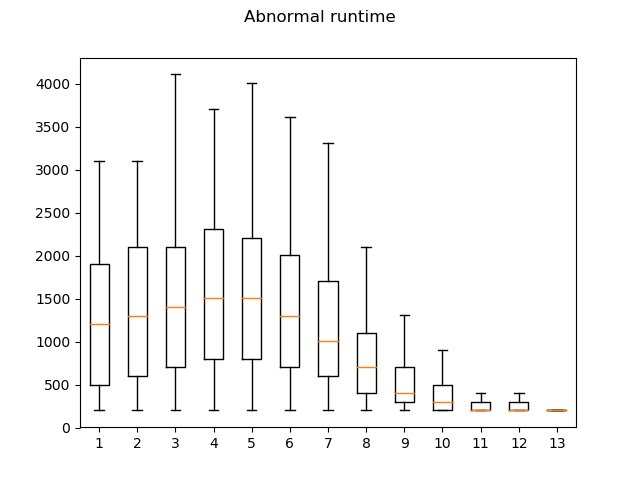

In [12]:
fig = plt.figure()

fig.suptitle('Abnormal runtime')

df_2 = merged_df[merged_df['result'] == 3]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

<IPython.core.display.Javascript object>


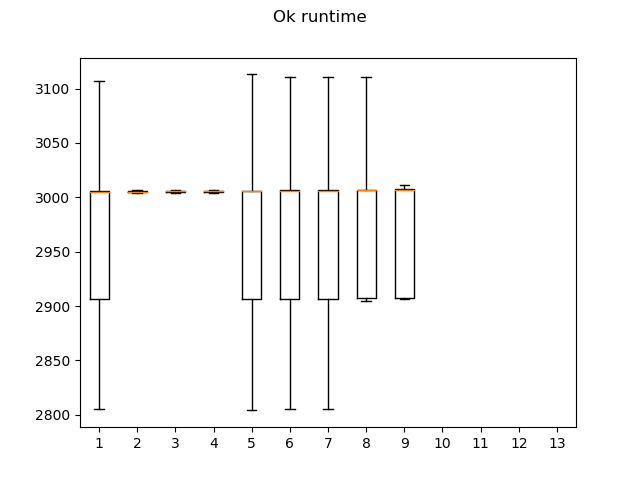

In [15]:
fig = plt.figure()

fig.suptitle('Ok runtime')

df_2 = merged_df[merged_df['result'] == 0]
data_2 = list(map(lambda x: list(df_2[df_2['rate'] == x]['runtime']), vals))

plt.boxplot(data_2, showfliers=False)
plt.show()

In [17]:
crashes = merged_df[merged_df['result'] == 2]
signals = crashes['term_sig'].unique()
crash_count = crashes.groupby(['term_sig', 'rate']).size().reset_index(name='counts')
crash_pivoted = pd.pivot_table(crash_count, values='counts', index='rate', columns='term_sig', fill_value=0)
crash_pivoted

term_sig,4,6,7,11
rate,,,,
0.0100,0,731,91,1393
0.0170,1,1074,122,1803
0.0310,0,1554,168,2516
0.0562,0,2713,368,4310
0.1000,0,4461,563,7101
0.1780,0,6368,845,10208
0.3100,0,7824,1088,12949
0.5620,1,8249,1265,14505
1.0000,0,8148,1420,14859


<IPython.core.display.Javascript object>


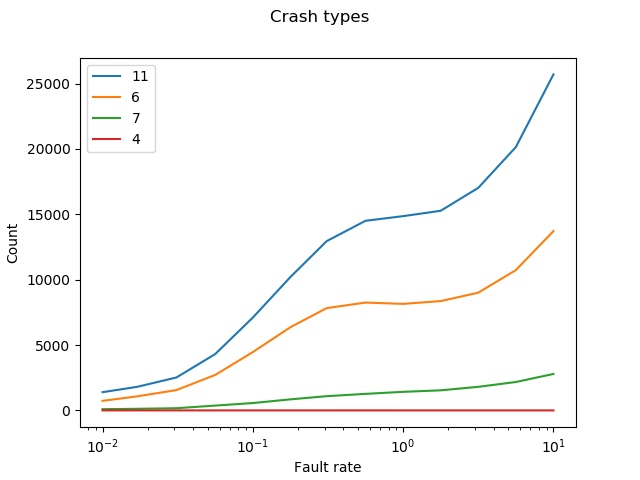

In [18]:
fig = plt.figure()
fig.suptitle('Crash types')
plt.ylabel('Count')
plt.xlabel('Fault rate')
plt.xscale('log')

for signal in signals:
    plt.plot(vals, crash_pivoted[signal], label=str(signal))
    
plt.legend()
plt.show()